# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [1]:
# Python Standard Library

# -----------------------
pass

In [2]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [3]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [4]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [5]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [6]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [7]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [8]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 

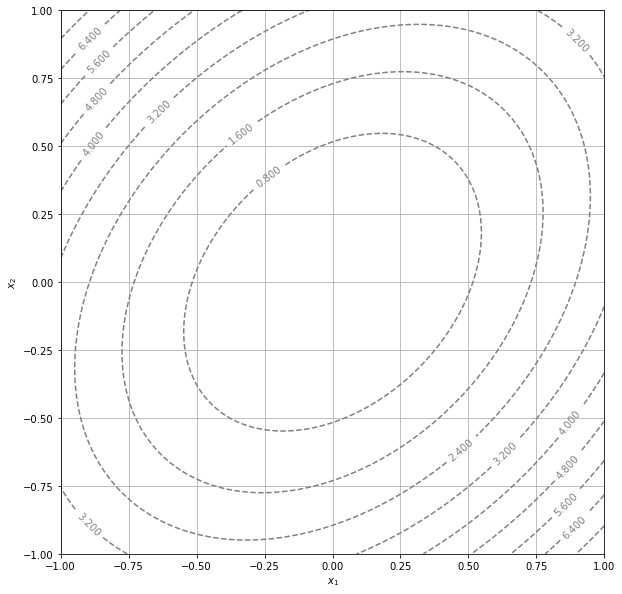

In [9]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [10]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

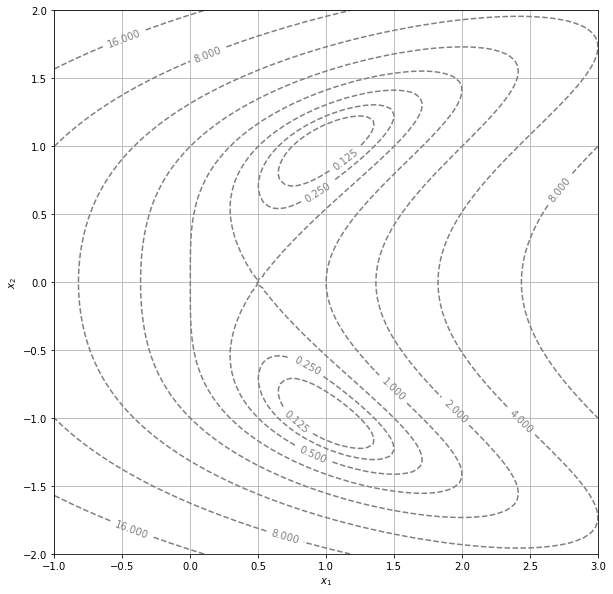

In [11]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [12]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

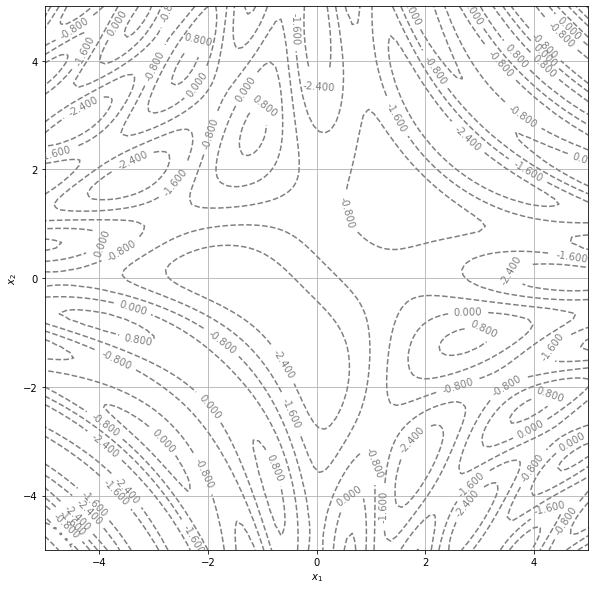

In [13]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

#### Réponse (question 1)

Montrons que $C$, défini comme étant égal à l'ensemble de niveau $c$ de $f$, est **compact**.

* $f$ est **continue** et $\{ c \}$ est **fermé** dans $\mathbb{R}$. Or, $C = f^{-1}(\{ c\})$. Comme image réciproque d'un fermé par une application continue, $C$ est **fermé dans $\mathbb{R}^2$**
* Comme $f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$, fixons $M \in \mathbb{R}_{+}$ tel que : $$\forall (x_1, x_2) \in \mathbb{R}^2, \|(x_1, x_2)\| \geq M \Rightarrow f(x_1, x_2) > c$$Par suite, $C \subset B_f(0, M)$. Ainsi, $C$ est **borné**.

*C* est **fermé borné en dimension finie**, c'est donc un **compact**.

Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Réponse (question 2)
Introduisons des notations afin de simplifier l'écriture :
##### Introduction des grandeurs
Posons $u=\begin{pmatrix}
x_1 - x_{10}\\
x_2 - x_{20}\\
\end{pmatrix}$ et $v=\begin{pmatrix}
-(x_2 - x_{20})\\
x_1 - x_{10}\\
\end{pmatrix}$ . De cette manière, la base $(u, v)$ est une base orthogonale directe du plan.

##### Interprétation
Remarquons que $p(x_1, x_2) = \left\langle {  \frac{\nabla f(x_0)}{\|\nabla f(x_0)\|}  } \middle| {~v} \right\rangle$. 

Ainsi, si $p(x_1, x_2)>0$, on dira intuituivement que $\nabla f(x_0)$ et $v$ "pointent dans le même sens". Plus précisemment, l'angle $(\nabla f(x_0), v)$ est dans l'intervalle $]-\frac{\pi}{2}, \frac{\pi}{2}[$.

En appliquant à $v$ une rotation d'angle $-\frac{\pi}{2}$, on obtient $u$. Ainsi, l'angle $(\nabla f(x_0), u)$ est compris dans $]0, -\pi[$.

Géométriquement, cela se traduit par le fait que le vecteur $u$ "pointe" vers la droite du gradient, donc que $(x_1, x_2)$ se situe dans le demi-plan à droite de la droite définie par $(x_0, \nabla f(x_0))$.

##### Conclusion
Par un raisonnement similaire dans le cas où $p(x_1, x_2)<0$ (ainsi que dans le cas d'égalité), on conclut que : $p(x_1, x_2)$ **détermine de quel côté de de la droite $(x_0, \nabla f(x_0))$ se trouve $(x_1, x_2)$** (à droite si c'est strictement positif, à gauche si c'est strictement négatif et sur l'axe du gradient si c'est nul).

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Réponse (question 3)

##### Définition d'une fonction auxiliaire

Définissons la fonction suivante : $$\psi:
\left\lbrace\begin{array}{ccc}
\mathbb{R}^2\times\mathbb{R} & \rightarrow & \mathbb{R}\\
(x_1, x_2, t) & \mapsto & \begin{pmatrix}
f(x_1, x_2) - c\\
p(x_1, x_2) - t\\
\end{pmatrix}\\
\end{array}\right.$$

On va lui appliquer le **théorème des fonctions implicites** au point $(x_{10}, x_{20}, 0)$ afin d'obtenir le résultat.

##### Vérification des hypothèses du théorème des fonctions implicites

* D'après les définitions de $c$ et de $p$, on a immédiatement $\psi(x_{10}, x_{20}, 0) = \begin{pmatrix}0\\0\end{pmatrix}$.
* $\psi$ est **continûment différentiable**. Par la propriété d'*assemblage*, démontrons-le composante par composante :
  * La première composante peut s'écrire $s \circ f \circ \pi$ où :
  $$\left\lbrace\begin{array}{ccccc}\pi &\text{ : }& (x_{1}, x_{2}, t) & \mapsto & (x_1, x_{2})\\ s & \text{ : } & r & \mapsto & r - c\\ \end{array}\right.$$
  $\pi$ est continument différentiable (linéaire), tout comme $f$ (par hypothèse) et $s$ (somme de l'identité et d'une fonction constante). Par *composition*, la première composante est continûment différentiable.
  * La deuxième composante l'est aussi comme somme de $q$ et de $-\pi'$ où :
  $$\left\lbrace\begin{array}{ccccc}\pi' & \text{ : } & (x_{1}, x_{2}, t) & \mapsto & t\\ q & \text{ = } & p \circ \pi && \\ \end{array}\right.$$
  A nouveau, en remarquant que $p$ est continûment différentiable (ses dérivées partielles *existent* et sont constantes donc *continues*), on obtient que la deuxième composante est continûment différentiable.
* Enfin, soit $t\in\mathbb{R}$ et considérons la fonction partielle $$\phi_t:
\left\lbrace\begin{array}{ccc}
\mathbb{R}^2 & \rightarrow& \mathbb{R}^2\\
(x_1, x_2) & \mapsto & \psi(x_1, x_2, t)\\
\end{array}\right.$$
Elle est différentiable, et sa matrice jacobienne s'écrit :
$$J_{\phi_t} (x_1, x_2) =
\begin{pmatrix}
\partial_1 f (x_1, x_2) & \partial_2 f (x_1, x_2)\\
\partial_1 p (x_1, x_2) & \partial_2 p (x_1, x_2)
\end{pmatrix}
=
\begin{pmatrix}
\partial_1 f (x_1, x_2) & \partial_2 f (x_1, x_2)\\
\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|}\\
\end{pmatrix}$$

En particulier, en $x_0$, $$\text{det}J_{\phi_t} (x_0) = -\frac{\partial_1 f(x_0)^2 + \partial_2 f(x_0)^2}{\|\nabla f(x_0)\|} = -\|\nabla f(x_0)\| < 0$$
En effet, le gradient est supposé non-nul en $x_0$. Ainsi, la différentielle de $\phi_t$ est inversible en $x_0$, ce qui suppose que l'on puisse trouver un voisinage autour de $x_0$ autour duquel la différentielle soit inversible. On applique par la suite le théorème en se restreignant à ce voisinage, ce qui ne change rien en pratique.

##### Conclusion

En appliquant le théorème des fonctions implicites, on obtient $V$ un voisinage de $0$ dans $\mathbb{R}$, un **voisinage $W$ ouvert de $x_0$** ainsi que $\gamma \text{ : } V \longrightarrow \mathbb{R}^2$ **continûment différentiable** tels que :
$$\forall (x_1, x_2, t) \in W \times V, \begin{pmatrix}f(x_1, x_2)-c\\p(x_1, x_2)-t\end{pmatrix} = \begin{pmatrix}0\\0\end{pmatrix} \Leftrightarrow (x_1, x_2) = \gamma (t)$$
En particulier, comme $V$ est un ouvert contenant 0, quitte à prendre $\varepsilon > 0$ tel que $]-\varepsilon, \varepsilon[ \subset V$, on obtient exactement ce qui est demandé : pour tout $(x_1, x_2) \in W$, $f(x_1, x_2) = c \Leftrightarrow (x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

#### Réponse (question 4)

Posons $U = ]-\varepsilon, \varepsilon[$.

##### Non-nullité de la dérivée

On sait que : $$\forall t \in U, \gamma'(t) = -(\text{d}\phi_t ( \gamma(t), t ))^{-1}\cdot \partial_3 \psi (\gamma(t), t)$$

Soit $t \in U$. Comme on travaille sur un voisinage de $x_0$ sur lequel $\text{d}\phi_t ( \gamma(t), t )$ est inversible, on a existence et inversibilité de $(\text{d}\phi_t ( \gamma(t), t ))^{-1}$. En particulier, cela suppose qu'elle soit **injective**. Or, $\partial_3 \psi (\gamma(t), t) = \begin{pmatrix}0\\-1\end{pmatrix} \ne 0$.

Ainsi, $\gamma'(t) \ne 0$ sur $]-\varepsilon, \varepsilon[$.

##### Orthogonalité

D'après la formule de la matrice jacobienne de $\phi_t (x_1, x_2)$ établie à la question précédente, il vient : $$(\text{d}\phi_t ( \gamma(t), t ))^{-1} =
-\frac{1}{\|\nabla f(x_0)\|}
\begin{pmatrix}
-\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} & -\partial_2 f (\gamma(t))\\
-\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & \partial_1 f (\gamma(t))\\
\end{pmatrix}
=
\frac{1}{\|\nabla f(x_0)\|}
\begin{pmatrix}
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} & \partial_2 f (\gamma(t))\\
\frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} & -\partial_1 f (\gamma(t))\\
\end{pmatrix}$$

D'où $\gamma'(t) = -\frac{1}{\|\nabla f(x_0)\|}\begin{pmatrix} -\partial_2 f (\gamma(t))\\ \partial_1 f (\gamma(t)) \\ \end{pmatrix}$. En calculant le produit scalaire on obtient immédiatement :

$$\left\langle {  \nabla f(\gamma(t))  ~} \middle| {~  \gamma'(t)   } \right\rangle = 0 $$

Donc pour tout $t \in \left]-\varepsilon, \varepsilon \right[$, $\gamma'(t)$ est orthogonal à $\nabla f(\gamma(t))$

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

#### Réponse (question 5)

Le but de notre méthode de Newton est de pouvoir tracer des courbes de niveau, la fonction n'a pas besoin d'être extrement précise (puisqu'on va observer des courbes). Il faut choisir un `eps` assez petit pour s'assurer que le point trouvé soit suffisamment proche de la solution réelle. Cependant, pour s'affranchir des erreurs d'arrondi, il faut choisir eps très grand devant l'epsilon-machine. Cela n'est pas un grand problème, car la méthode de Newton converge très rapidement. Un eps de l'ordre de $10^{-6}$ semble donc cohérent

In [14]:
N = 100
eps = 10**(-6)

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [15]:
# Fonction implémentant l'algorithme de la méthode de Newton
# Elle prend en argument une fonction F de R2 dans R2, un point (x0, y0) de départ, ainsi que eps et N optionnels
# Elle retourne un point (x, y), solution approchée de F = 0.

def Newton(F, x0, y0, eps=eps, N=N):
    # Calcul de la jacobienne avant la boucle pour économiser les calculs
    jacob = J(F)
    for i in range(N):
        # Calcul du terme suivant
        xi = np.array([x0, y0])
        inversee = np.linalg.inv((jacob(x0, y0)))
        xi1 = xi - inversee.dot((F(x0, y0)))
        
        x = xi1[0]
        y = xi1[1]
        
        # Test de précision
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y
        x0, y0 = x, y
        
        
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

#### Réponse (tâche 2)

Les vérifications sont faites dans les 3 cellules suivantes :
* la première vérifie qu'en partant de $(0.8, 0.8)$ et à l'aide des conditions $f_1(x_1, x_2) = 0.8$ et $x_1 = x_2$, on arrive bien à un point sur la ligne de niveau de $0.8$
* la deuxième fait varier le point initial, tout en gardant les mêmes conditions. Pour chaque série de points calculée par la méthode de Newton, le point de départ est affiché en bleu, le point d'arrivée en rouge et les points intermédiaires en noir. La courbe pointillée verte relie les points successifs.
* la troisième fait varier la condition supplémentaire, tout en en gardant le même point initial. Le code couleur est le même.

In [16]:
# Vérification 1 : point initial = (0.8, 0.8) ; condition f1 = 0.8 ; condition supplémentaire x1 = x2
c = 0.8

# Fonction auxiliraire
def funct1(x1, x2):
    return np.array([f1(x1, x2) - c, x1-x2])


x10 = 0.8
x20 = 0.8

x1, x2 = Newton(funct1, x10, x20)

print("Point de départ : (", x10, ", ", x20, ")")
print("Conditions sur la méthode de Newton : f1(x1, x2) - c = 0 et x1-x2 = 0")
print("Point trouvé : (", x1, ", ", x2, ")")
print("En ce point, f1 vaut : ", f1(x1, x2))



Point de départ : ( 0.8 ,  0.8 )
Conditions sur la méthode de Newton : f1(x1, x2) - c = 0 et x1-x2 = 0
Point trouvé : ( 0.4472135954999579 ,  0.4472135954999579 )
En ce point, f1 vaut :  0.8


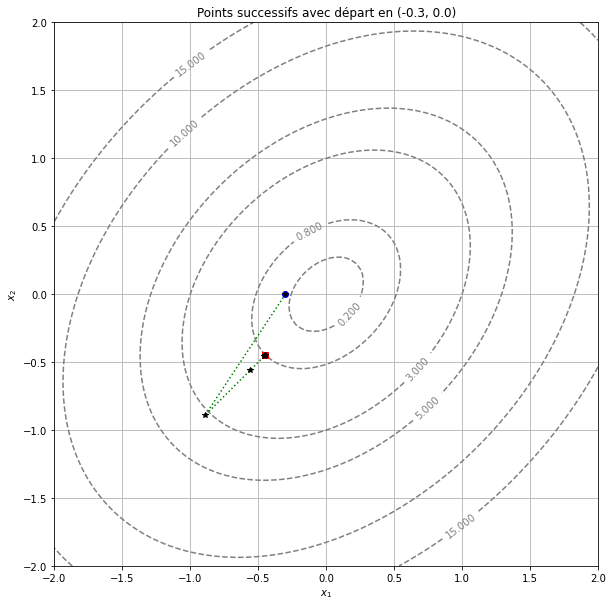

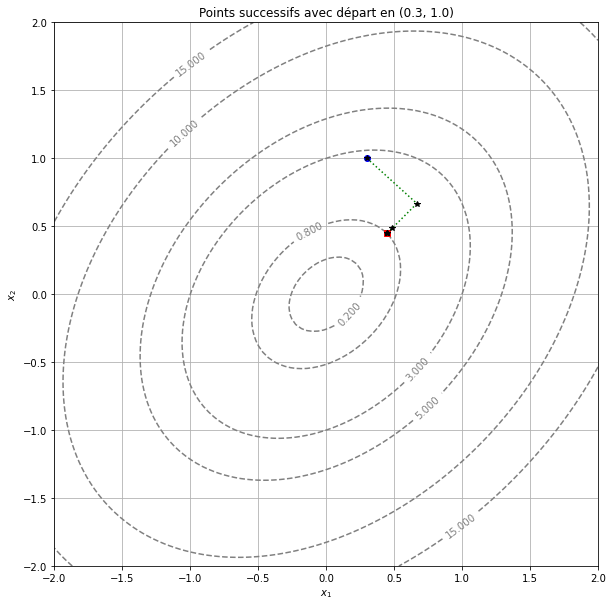

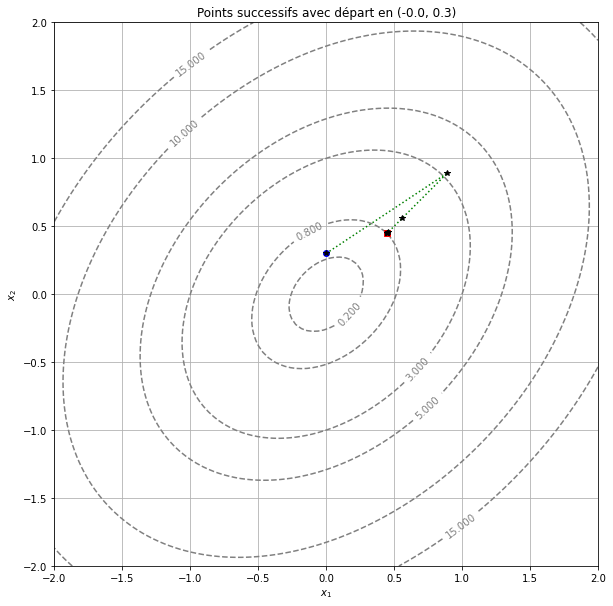

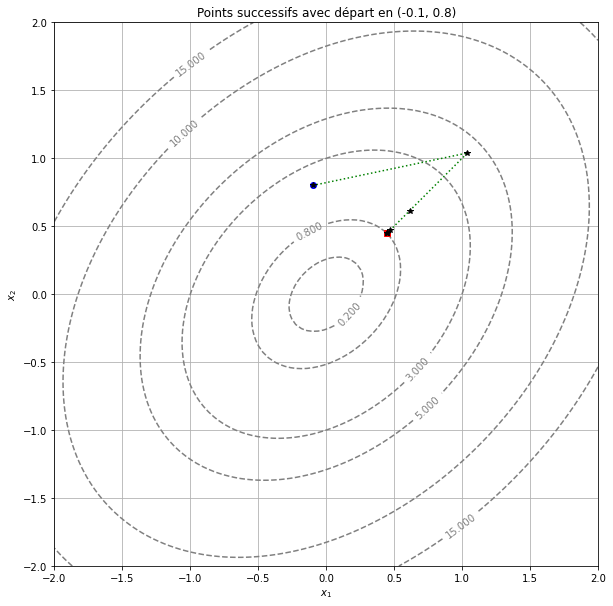

In [17]:
# Vérification 2 : variation du point initial ; condition f1 = 0.8 ; condition supplémentaire x1 = x2
c = 0.8

# Fonction implémentant l'algorithme de la méthode de Newton, en version modifiée
def NewtonBis(F, x0, y0, eps=eps, N=N):
    abscisses = [x0]
    ordonnees = [y0]
    
    # Calcul de la jacobienne avant la boucle pour économiser les calculs
    jacob = J(F)
    for i in range(N):
        # Calcul du terme suivant
        xi = np.array([x0, y0])
        inversee = np.linalg.inv((jacob(x0, y0)))
        xi1 = xi - inversee.dot((F(x0, y0)))
        
        x = xi1[0]
        y = xi1[1]
        
        abscisses.append(x)
        ordonnees.append(y)
        
        # Test de précision
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return np.array([abscisses, ordonnees])
        x0, y0 = x, y
        
        
    else:
        raise ValueError(f"no convergence in {N} steps.")

points_depart = [
    [-0.3, 0.0],
    [0.3, 1.0],
    [-0.0, 0.3],
    [-0.1, 0.8]
]




for point_depart in points_depart:
    x10 = point_depart[0]
    x20 = point_depart[1]
    points = NewtonBis(funct1, float(x10), float(x20))
    
    display_contour(
    f1, 
    x=np.linspace(-2.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[0.2, 0.8, 3.0, 5.0, 10.0, 15.0])
    
    plt.plot(points[0][0], points[1][0], "ob")
    plt.plot(points[0][-1], points[1][-1], "sr")
    plt.plot(points[0], points[1], ":g")
    plt.plot(points[0], points[1], "*k")
    
    titre = "Points successifs avec départ en (" + str(x10) + ", " + str(x20) + ")"
    plt.title(titre)
    plt.show()



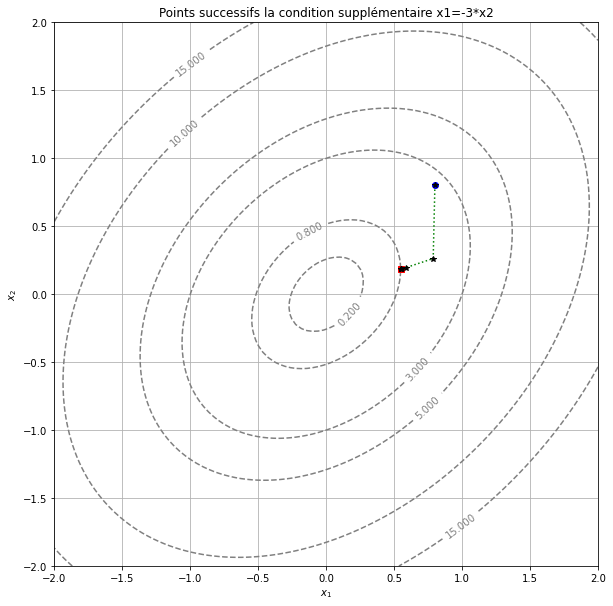

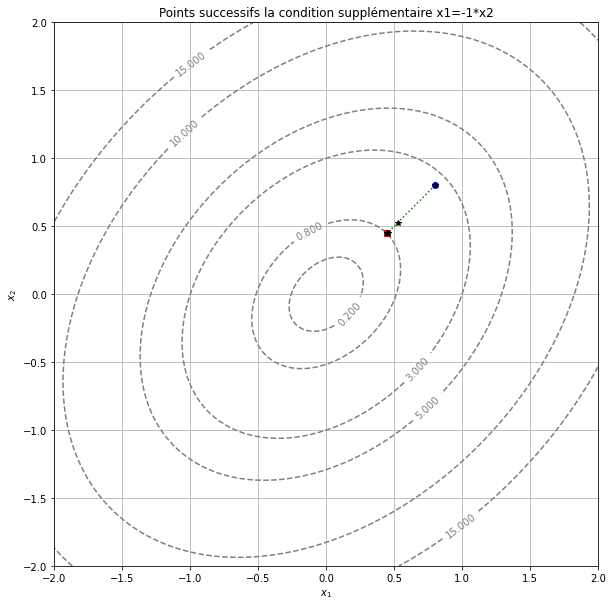

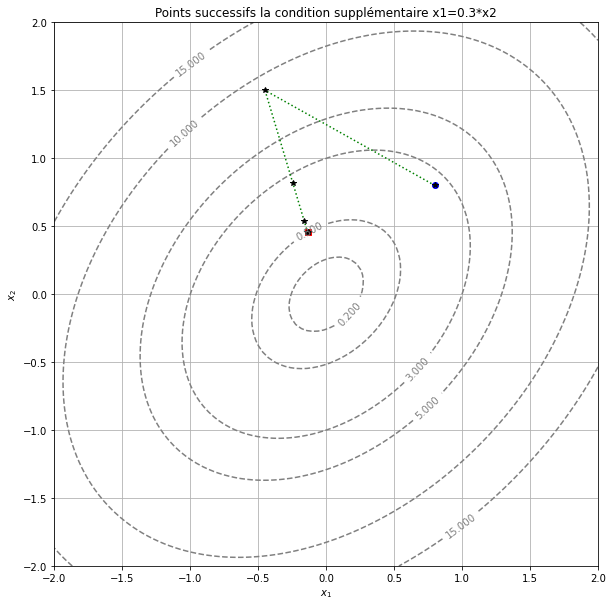

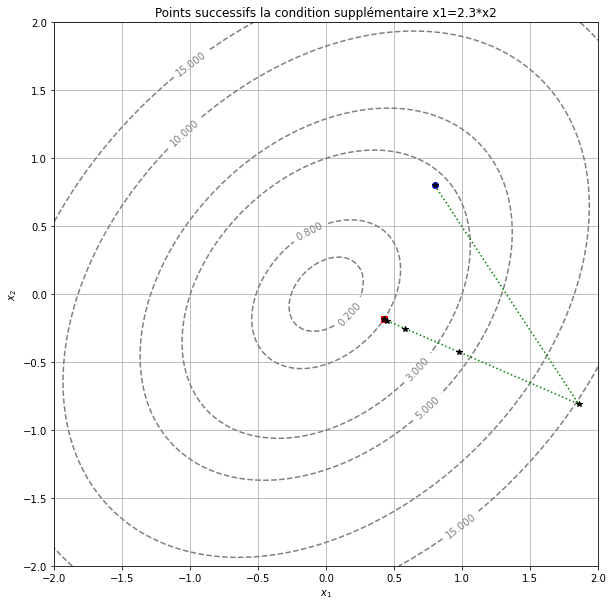

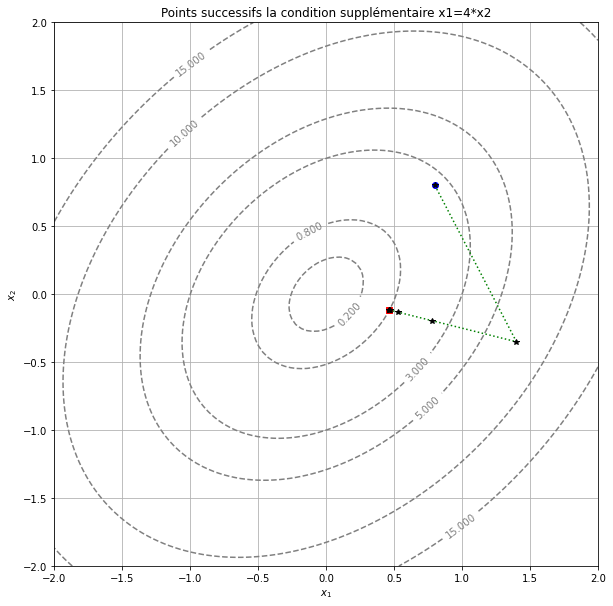

In [18]:
# Vérification 3 : point initial = (0.8, 0.8) ; condition f1 = 0.8 ; condition supplémentaire variable

c = 0.8

# Fonction auxiliaire
def funct2(k):
    def funct(x1, x2):
        return np.array([f1(x1, x2) - c, x1+k*x2])
    return funct

x10 = 0.8
x20 = 0.8

ks = [-3, -1, 0.3, 2.3, 4]

for k in ks:
    points = NewtonBis(funct2(k), float(x10), float(x20))
    
    display_contour(
    f1, 
    x=np.linspace(-2.0, 2.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[0.2, 0.8, 3.0, 5.0, 10.0, 15.0])
    
    plt.plot(points[0][0], points[1][0], "ob")
    plt.plot(points[0][-1], points[1][-1], "sr")
    plt.plot(points[0], points[1], ":g")
    plt.plot(points[0], points[1], "*k")
    
    titre = "Points successifs la condition supplémentaire x1=" + str(k) + "*x2"
    plt.title(titre)
    plt.show()

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

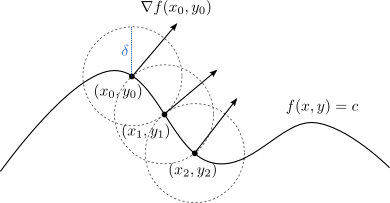

#### Réponse (question 6)

Pour simplifier l'explication, on explicite la construction d'un point $h_{i+1}$, lorsque l'on connaît déjà un point $h_i$ sur la courbe de niveau. Il suffira ensuite d'intégrer ce raisonnement dans une boucle à $n$ itérations pour construire les points les uns après les autres.

##### Idée retenue

Pour construire le $h_{i+1}$, on utilise la **méthode de Newton** comme suit :
* on trouve un point $h'$ qui vérifie les 3 hypothèses suivantes :
  * $h'$ est à une distance $\delta$ de $h_i$ (1)
  * $h'$ est proche de la courbe de niveau (2)
  * $h'$ est "*à droite du gradient en $h_i$*" (3)
* on applique la méthode de Newton, en partant de $h'$, pour trouver un point $x_{i+1}$ :
  * à une distance $\delta$ de $h_{i}$ (4)
  * sur la courbe de niveau (5)

Comme $h'$ est déjà "*à droite du gradient en $h_i$*" et qu'il remplit presque les conditions demandées pour $x_{i+1}$, on suppose que $x_{i+1}$ sera proche de $h'$ et donc lui aussi "*à droite du gradient en $h_i$*".

##### Formalisation : construction de $h'$

On construit le point $h'$ comme suit :
$$h' = h_i + \frac{\delta}{\|\nabla f(h_i) \|} \begin{pmatrix} \partial_2 f(h_i) \\ -\partial_1 f(h_i) \end{pmatrix}$$

* On remarque qu'il vérifie immédiatement l'exigence (1).
* Pour l'exigence (2) remarquons que $\left(u, \nabla f(h_i) \right)$ où $u=\begin{pmatrix} \partial_2 f(h_i) \\ -\partial_1 f(h_i) \end{pmatrix}$ est une base orthogonale directe. De cette manière, translater $h_i$ de $u$ induit un décalage orthogonal au gradient, *ie* parallèle à la ligne de niveau. Ainsi, on peut supposer que si $\delta$ est suffisamment petit, $h'$ est proche de la courbe de niveau.
* On utilise le même raisonnement pour l'exigence (3) : le caractère direct de la base implique que translater $h_i$ de $u$ revient bien à décaler $h_i$ vers la droite, par rapport au gradient en $h_i$.

##### Formalisation : méthode de Newton

Posons : $$\psi \text{ : }
\left\lbrace\begin{array}{ccc} \mathbb{R}^2 & \rightarrow & \mathbb{R}^2\\
                         (x, y) & \mapsto & \begin{pmatrix}f(x, y) - c\\ (x-{h_i}_x)^2 + (y-{h_i}_y)^2 - \delta^2 \end{pmatrix}\\ \end{array} \right.$$
                         
En appliquant la **méthode de Newton** à $\psi$, la condition $\psi = 0$ se traduit exactement par l'exigence (4) et (5).

##### Conclusion

En itérant ce processus $n-1$ fois, on obtient tous les points nécessaires.

#### Réponse (tâche 3)

La réponse à la tâche 3 se matérialise par les quatre cellules de code suivantes :
* La cellule ci-dessous implémente cet algorithme.
* Les cellules suivantes se chargent de vérifier graphiquement les résultats. Pour cela, on a vérifié sur les 3 fonctions de référence le tracé d'une courbe de niveau. Concrètement :
  * pour une valeur $c$ donnée :
    * pour $f_2$ et de $f_3$, on trouve un point évident sur la courbe de niveau
    * pour $f_1$, on choisit à la main un point proche de la courbe de niveau $c$ ; l'algorithme trouve alors un point $(x_0, y_0)$ vérifiant $f(x_0, y_0) = c$ à l'aide de la méthode de Newton et du travail effectué à la tâche 1.
  * dans tous les cas, on a un point qui vérifie exactement les hypothèses pour appliquer la fonction `level_curve`. Les points calculés sont ensuite affichés en superposition avec des courbes de niveau tracées par la fonction `display_contour`. On a trouvé manuellement le nombre de points à afficher pour éviter de faire plusieurs fois le tour de la courbe de niveau.

##### Fonction `level_curve`

In [19]:
# Fonction auxiliaire, celle utilisée pour utiliser la méthode de Newton (psi dans l'explication)
def F(x0, y0, delta, f) :
    def funct(x, y) :
        X = f(x, y) - c
        # condition sur la distance entre les deux points, comme deuxieme composante de la fonction
        Y = (x0-x)**2 + (y0-y)**2 - delta**2
        return(np.array([X, Y]))
    return funct



# Fonction auxiliaire.
# Trouve le point situé après (x, y) à une distance delta
def suivant(x, y, f, delta):
    # Calcul du point de départ, situé "un peu à droite" du point précédent
    gradient_point_i = grad(f)(x, y)
    norme_gradient_point_i = np.linalg.norm(gradient_point_i)
    u = np.array([gradient_point_i[1], -gradient_point_i[0]])
    u *= (delta/norme_gradient_point_i)
    depx, depy = x + u[0], y + u[1]

    # Calcul du point suivant
    return Newton(F(x, y, delta, f), depx, depy)
    

    
    
# x0, y0 : point de départ pour obtenir les points de tracé de la courbe de niveau c
# delta : distance entre chaque point de la courbe de niveau
# n : nombre de points
# eps : l'eps de la méthode de Newton
def level_curve(f, x0, y0, delta = 0.1, n = 150, eps = eps):
    X = [x0]
    Y = [y0]
    
    # Coordonnées du ie point
    xi = x0
    yi = y0

    for i in range(1, n):
        xi1, yi1 = suivant(xi, yi, f, delta)
        
        X.append(xi1)
        Y.append(yi1)
        xi = xi1
        yi = yi1

    return(np.array([X, Y]))

##### Vérification graphique pour `f1`

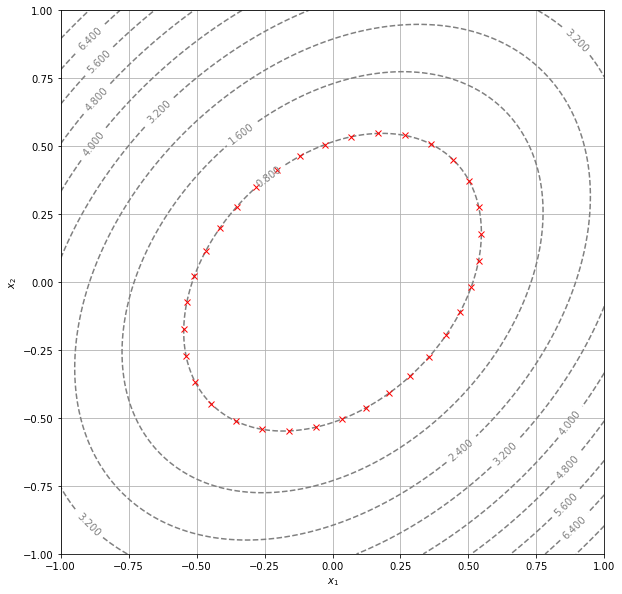

In [20]:
# Validation avec f1 :

# Choix de la courbe de niveau, et point initial
c = 0.8
x0, y0 = Newton(funct1, -0.45, -0.45)
tab = level_curve(f1, x0, y0, n = 34)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

##### Vérification graphique pour `f2`

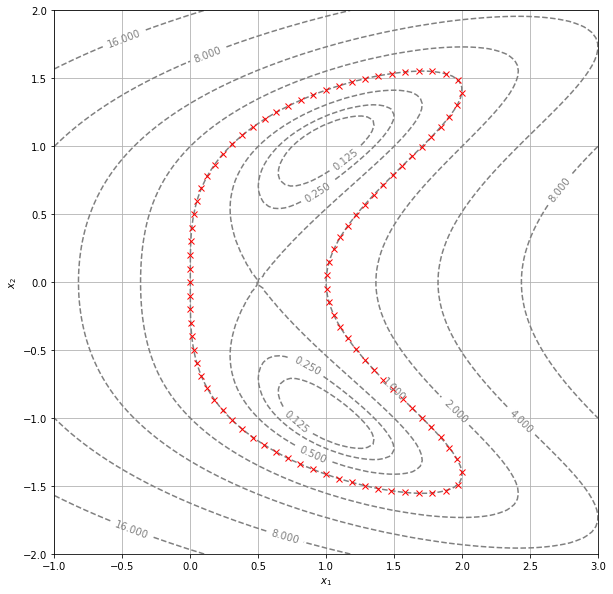

In [21]:
# Validation avec f2 :

# Choix de la courbe de niveau et du point initial
c = 1.0
x0 = 0.0
y0 = 0.0
tab = level_curve(f2, x0, y0, n = 95)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)]
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

##### Vérification graphique pour `f3`

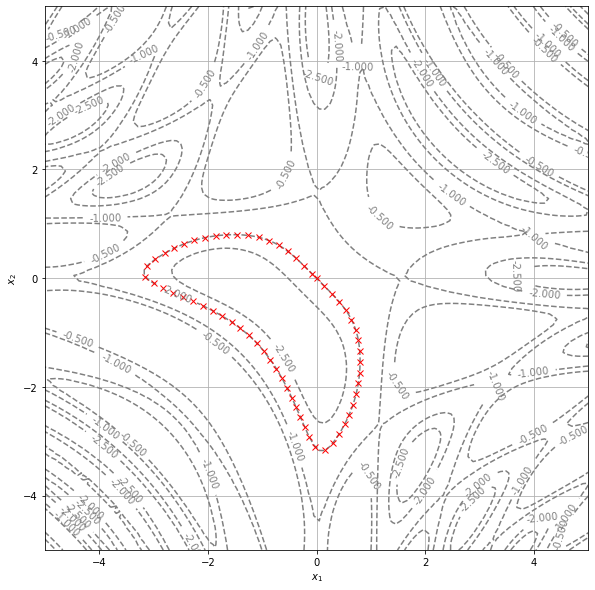

In [22]:
# Validation avec f3 :

# Choix de la courbe de niveau et du point initial
c = -2
x0 = 0.0
y0 = 0.0
tab = level_curve(f3, x0, y0, n = 61, delta = 0.2)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100),
    levels=[-3, -2.5, -2, -1, -0.5]
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

#### Réponse (question 7)

* La **nouvelle implémentation** se situe dans la cellule suivante, dans la fonction `level_curve2`.
* Tant que la courbe ne s'auto-intersecte pas, il est logique que pour croiser un des segments précédents il faille repasser par le premier.
* Si elle s'auto-intersecte, il se peut très bien que le croisement se produise sur un segment quelconque.

Cependant, les lignes de niveau qui se croisent sont rares. En effet, soit $x_0$ un point d'intersection d'une courbe de niveau $c$. Le gradient étant orthogonal à la ligne de niveau, **le gradient en $x_0$ est nécessairement nul** (sans quoi il devrait être selon deux directions non-colinéaires à la fois).

Cette condition étant très spécifique, on peut raisonnablement supposer en connaissant la précision des calculs avec les doubles, qu'elle se rencontre assez rarement.

Ainsi, vérifier l'intersection avec le premier segment sera suffisant dans la plupart des cas.

#### Réponse (tâche 4)

Le code suivant implémente ce qui a été discuté ci-dessus. Remarquons au passage que le premier point est calculé en dehors de la boucle, pour éviter la vérification d'intersection.

En effet, celle-ci donne toujours un résultat positif lorsque les segments vérifiés sont identiques (ce qui est le cas ici puisque l'on testerai le premier segment avec lui-même)

In [23]:
# Fonction auxiliaire qui calcule ax+by+c
# En fonction de son signe représente de quel côté de la droite ax+by+c=0 se situe le point
def CoteDroite(a, b, c, point) :
    x = point[0]
    y = point[1]
    return a*x +b*y +c




# Fonction auxiliaire : indique si les segments [A0, A1] et [An, An1] se croisent
def Intersect(A0, A1, An, An1):
    #Premier test : An et An1 sont-ils du même côté de la droite (A0A1) ?
    
    
    #Coefficients de l'équation de la droite (A0A1)
    a = A1[1] - A0[1]
    b = A0[0] - A1[0]
    c = A1[0]*A0[1] - A0[0]*A1[1]

    
    if CoteDroite(a, b, c, An)*CoteDroite(a, b, c, An1) >= 0 :
        # Les points An et An1 sont du même côté de la droite (A0A1)
        return False

    if CoteDroite(a, b, c, An)*CoteDroite(a, b, c, An1) < 0 :
        # Les points sont de part et autre (strictement) de la droite
        # Deuxième test : de même, les points A0 et A1 sont-ils de part et d'autre de la droite (AnAn1) ?
        
        
        # Coefficients de l'équation de la droite (AnAn1)
        a = An1[1] - An[1]
        b = An[0] - An1[0]
        c = An1[0]*An[1] - An[0]*An1[1]

        
        if CoteDroite(a, b, c, A0)*CoteDroite(a, b, c, A1) >= 0 :
            # Les points An et An1 sont du même côté de la droite (A0A1)
            return False
        
        if CoteDroite(a, b, c, A0)*CoteDroite(a, b, c, A1) < 0 :
            # Les points sont de part et d'autre (strictement) de la droite ou sur la droite
            return True
        






# x0, y0 : point de départ pour obtenir les points de tracé de la courbe de niveau c
# delta : distance entre chaque point de la courbe de niveau
# n : nombre de points
# eps : l'eps de la méthode de Newton
# Cette fonction s'arrête une fois que l'on a fait un tour de la courbe de niveau
def level_curve2(f, x0, y0, delta = 0.1, n = 150, eps = eps):
    X = [x0]
    Y = [y0]
    
    premiere_iter = True

    A0 = [x0, y0]
    A1 = [x0, y0]
    
    xi = x0
    yi = y0

    for i in range(1, n):
        xi1, yi1 = suivant(xi, yi, f, delta)

        # Vérifions l'intersection avec le segment initial
        An = [xi, yi]
        An1 = [xi1, yi1]

        if premiere_iter:
            premiere_iter = False
            A1 = [xi1, yi1]
        elif Intersect(A0, A1, An, An1):
            return(np.array([X, Y]))
        
        X.append(xi1)
        Y.append(yi1)

        xi = xi1
        yi = yi1

    return(np.array([X, Y]))

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

#### Réponse (tâche 5)

Le processus de vérification est le même qu'à la tâche 3, à ceci près qu'on utilise la nouvelle fonction `level_curve2`

##### Vérification graphique pour `f1`

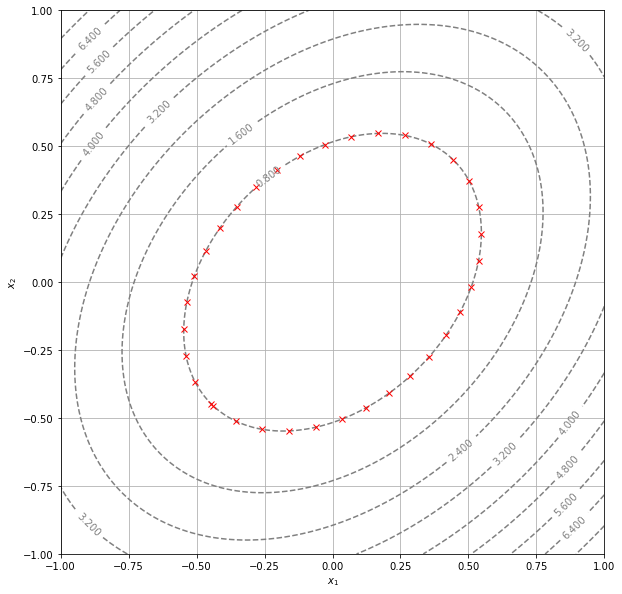

In [24]:
# Validation avec f1 :

# Choix de la courbe de niveau, et point initial
c = 0.8
x0, y0 = Newton(funct1, -0.45, -0.45)
tab = level_curve2(f1, x0, y0, n = 500)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

##### Vérification graphique pour `f2`

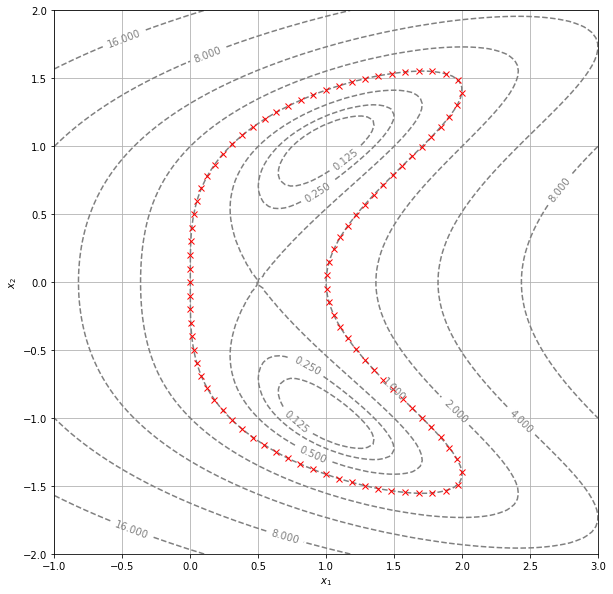

In [25]:
# Validation avec f2 :

# Choix de la courbe de niveau et du point initial
c = 1.0
x0 = 0.0
y0 = 0.0
tab = level_curve2(f2, x0, y0, n=500)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)]
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

##### Vérification graphique pour `f3`

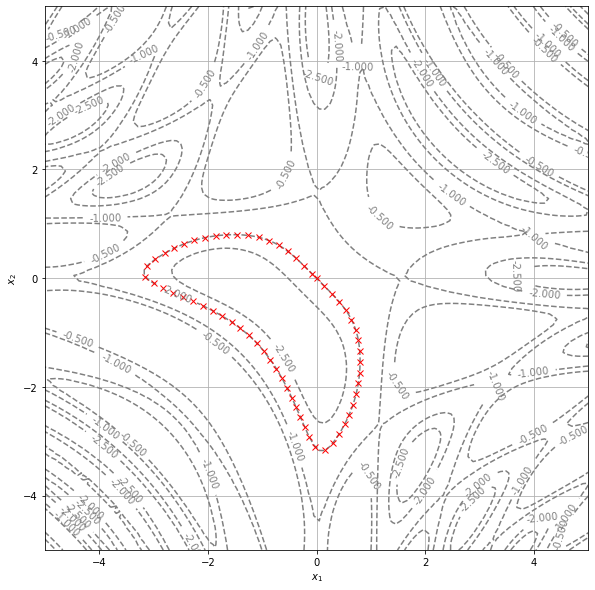

In [26]:
# Validation avec f3 :

# Choix de la courbe de niveau et du point initial
c = -2
x0 = 0.0
y0 = 0.0
tab = level_curve2(f3, x0, y0, delta = 0.2, n=500)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100),
    levels=[-3, -2.5, -2, -1, -0.5]
)


plt.plot(tab[0], tab[1], 'rx')
plt.show()

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Réponse (question 8)

Remarquons déjà que si de tels coefficients existent, alors $\gamma$ associé sera bien continûment différentiable.

Par la suite, on notera $P_i = (x_i, y_i)$ ainsi que $u_i = (x_{u_i}, y_{u_i})$ pour $i \in \lbrace1, 2\rbrace$.

##### Ecriture des systèmes

* Les conditions $\gamma(0)= P_1$ et $\gamma(1)= P_2$ se traduisent par :
$$\left\lbrace\begin{array}{ccc} a & = & x_1\\ d & = & y_1\end{array}\right.$$
et $$\left\lbrace\begin{array}{ccc} a + b + c & = & x_2\\ d + e + f & = & y_2\end{array}\right.$$

En particulier, on a déjà **trouvé les valeurs de $a$ et de $d$**. On obtient le système suivant, noté $(1)$ par la suite, en soustrayant le premier système au deuxième :
$$\left\lbrace\begin{array}{ccc} b + c & = & x_2 - x_1\\ e + f & = & y_2 - y_1\end{array}\right.$$

* La condition de même direction et de même sens se traduit par le fait qu'il existe $k \geq 0$ tel que $\gamma'(0) = ku_1$ (car $u_1$ non-nul). Idem pour $\gamma'(1)$ avec un $l \geq 0$. Ainsi :

$$\left\lbrace\begin{array}{ccc} b & = & kx_{u_1}\\ e & = & ky_{u_1}\end{array}\right.$$ et
$$\left\lbrace\begin{array}{ccc} b + 2c & = & lx_{u_2}\\ e + 2f & = & ly_{u_2}\end{array}\right.$$

En particulier, **on a trouvé les valeurs de $b$ et $e$ en fonction de $k$**. En soustrayant, on obtient le système suivant, noté $(2)$ par la suite :

$$\left\lbrace\begin{array}{ccc} c & = & 0.5(lx_{u_2} - kx_{u_1})\\ f & = & 0.5(ly_{u_2} - ky_{u_1})\end{array}\right.$$

* Puis $(1) - (2)$ donne le système $(3)$ suivant :
$$\left\lbrace\begin{array}{ccc} b & = & x_2 - x_1-0.5(lx_{u_2} - kx_{u_1})\\ e & = & y_2 - y_1 - 0.5(ly_{u_2} - ky_{u_1})\end{array}\right.$$

##### Etude des conditions

On obtiendra des solutions si $(3)$ est compatible avec les valeurs de $b$ et $e$ trouvées ci-dessus. En soustrayant les deux systèmes :

$$\left\lbrace\begin{array}{ccc} x_{u_1}k + x_{u_2}l = 2(x_2 - x_1)\\ y_{u_1}k + y_{u_2}l = 2(y_2 - y_1)\end{array}\right.$$

* Si la matrice $\begin{pmatrix} u_1 & u_2 \end{pmatrix}$ est **inversible**, alors par les formules de Cramer :

$$\left\lbrace\begin{array}{ccc} k & = & 2\frac{y_{u_2}(x_2 - x_1) - x_{u_2}(y_2 - y_1)}{\text{det}(u_1, u_2)}\\ l & = & 2\frac{ - y_{u_1}(x_2 - x_1) + x_{u_1}(y_2 - y_1)}{\text{det}(u_1, u_2)}\end{array}\right.$$

La condition pour que $k \geq 0$ et $l \geq 0$ est donc :
$$\left\lbrace\begin{array}{ccc} (y_{u_2}(x_2 - x_1) - x_{u_2}(y_2 - y_1))(x_{u_1}y_{u_2} - x_{u_2}y_{u_1}) & \geq & 0\\(- y_{u_1}(x_2 - x_1) + x_{u_1}(y_2 - y_1))(x_{u_1}y_{u_2} - x_{u_2}y_{u_1}) & \geq & 0\end{array}\right.$$

  * Si cette condition n'est pas vérifiée, il n'y a aucune solution au problème et on choisira donc une interpolation linéaire.
  * Si elle l'est, alors on connaît les valeurs d'après les équations établies précédemment :
  

  
  
$$\left\lbrace\begin{array}{ccc}
a & = & x_1\\
b & = & kx_{u_1} \\
c & = & x_2 - x_1 - kx_{u_1}\\
d & = & y_1\\
e & = & ky_{u_1}\\
f & = & y_2 - y_1 - ky_{u_1}\\
\end{array}\right., ~~~\text{ avec } k = 2\cdot\frac{y_{u_2}(x_2 - x_1) - x_{u_2}(y_2 - y_1)}{\text{det}(u_1, u_2)}$$






* Dans le cas où $A$ n'est pas inversible, les conditions sont très complexes à implémenter. Etant donné le peu de cas où $\text{det}A = 0$ (condition très contraignante, à cause notamment des imprécisions sur les flottants), on implémentera simplement une interpolation linéaire.


##### Conclusion

* Si la matrice $\begin{pmatrix}u_1, u_2\end{pmatrix}$ est inversible, et que les deux inégalités citées plus haut sont vérifiées, alors les solution existent et sont données par le système ci-dessus
* Si ce n'est pas le cas, on choisira l'interpolation linéaire (les solutions n'existent pas ou sont trop compliquées à expliciter)

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




#### Réponse (tâche 6)

##### Code de la fonction $\gamma$

In [27]:
def gamma(t, P1, P2, u1, u2):
    det = u1[0]*u2[1] - u1[1]*u2[0]

    if det != 0 :
        #condition sur k et l
        #kp et lp sont tels que k = 2*kp et l = 2*lp
        kp = (u2[1]*(P2[0] - P1[0]) - u2[0]*(P2[1] - P1[1]))/det
        lp = (-u1[1]*(P2[0] - P1[0]) + u1[0]*(P2[1] - P1[1]))/det

        if kp >= 0 and lp >=0 :
            k = 2 * kp
            a = P1[0]
            b = k * u1[0]
            c = P2[0] - P1[0] - k*u1[0]
            d = P1[1]
            e = k * u1[1]
            f = P2[1] - P1[1] - k*u1[1]

            X = a + b*t + c*(t**2)
            Y = d + e*t + f*(t**2)

            gam = np.array([X, Y])

            return gam

    # Les conditions ne sont pas vérifiées ; on interpole linéairement les deux points
    X = (P2[0] - P1[0])*t + P1[0]
    Y = (P2[1] - P1[1])*t + P1[1]

    gam = np.array([X, Y])
    return gam

##### Validation graphique

On propose deux exemples de validation graphique :
* un premier où les conditions sont respectées. On remarque alors que l'interpolation réalise bien un chemin qui correspond à l'intuition.
* un deuxième où $u_1$ et $u_2$ sont colinéaires (c'est-à-dire que $\text{det}(u_1, u_2) = 0$). Intuitivement, on comprend pourquoi dans l'exemple, aucun chemin ne peut être trouvé : cela impliquerait que la trajectoire ne soit pas parabolique
* un dernier où $u_1$ et $u_2$ ne sont pas colinéaires, mais ne respectent pas la deuxième condition évoquée. Intuitivement, on comprend à nouveau pourquoi on ne peut pas trouver de chemin : cela impliquerait une trajectoire non-parabolique

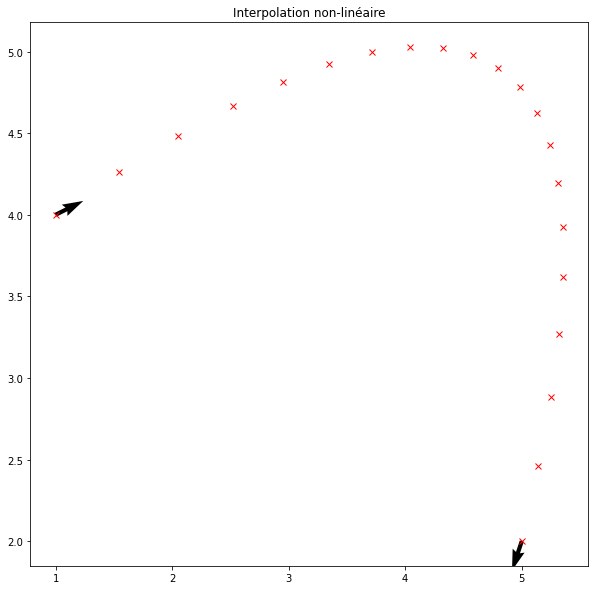

In [28]:
# Validation graphique 1

P1 = np.array([1, 4])
P2 = np.array([5, 2])
u1 = np.array([8, 4])
u2 = np.array([-3, -9])
t = np.array([k*0.05 for k in range(0, 21)])

gam = gamma(t, P1, P2, u1, u2)

ax = plt.axes()
ax.quiver(P1[0], P1[1], u1[0], u1[1])
ax.quiver(P2[0], P2[1], u2[0], u2[1])

plt.plot(P1[0], P1[1], label = 'P1')
plt.plot(P2[0], P2[1], label = 'P2')
plt.title("Interpolation non-linéaire")

plt.plot(gam[0], gam[1], 'rx')

plt.show()

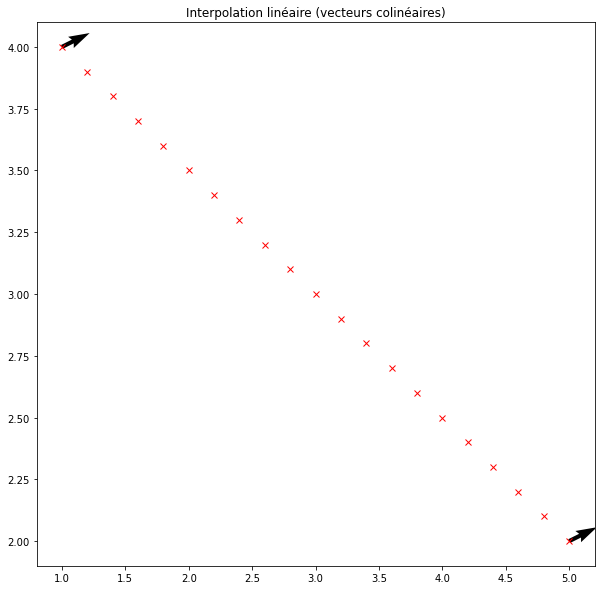

In [29]:
# Validation graphique 2 : les vecteurs sont colinéaires

P1 = np.array([1, 4])
P2 = np.array([5, 2])
u1 = np.array([8, 4])
u2 = np.array([4, 2])
t = np.array([k*0.05 for k in range(0, 21)])

gam = gamma(t, P1, P2, u1, u2)

ax = plt.axes()
ax.quiver(P1[0], P1[1], u1[0], u1[1])
ax.quiver(P2[0], P2[1], u2[0], u2[1])

plt.plot(P1[0], P1[1], label = 'P1')
plt.plot(P2[0], P2[1], label = 'P2')
plt.title("Interpolation linéaire (vecteurs colinéaires)")

plt.plot(gam[0], gam[1], 'rx')

plt.show()

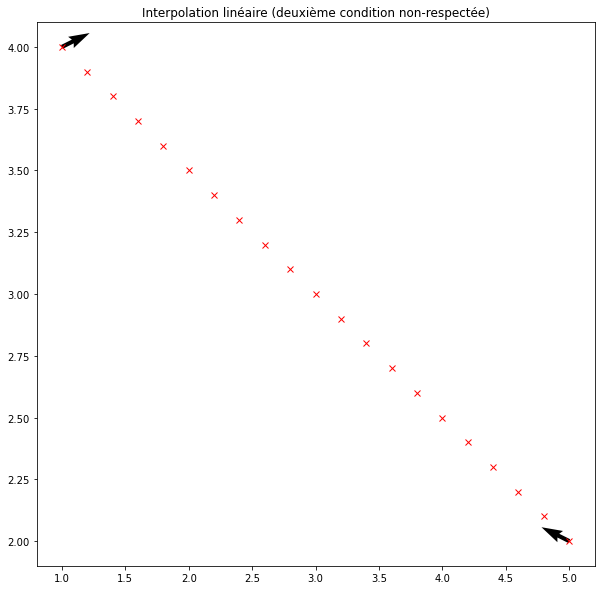

In [30]:
# Validation graphique 3 : la condition supplémentaire n'est pas vérifiée

P1 = np.array([1, 4])
P2 = np.array([5, 2])
u1 = np.array([8, 4])
u2 = np.array([-4, 2])
t = np.array([k*0.05 for k in range(0, 21)])

gam = gamma(t, P1, P2, u1, u2)

ax = plt.axes()
ax.quiver(P1[0], P1[1], u1[0], u1[1])
ax.quiver(P2[0], P2[1], u2[0], u2[1])

plt.plot(P1[0], P1[1], label = 'P1')
plt.plot(P2[0], P2[1], label = 'P2')
plt.title("Interpolation linéaire (deuxième condition non-respectée)")

plt.plot(gam[0], gam[1], 'rx')

plt.show()

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

#### Réponse (tâche 7)

On reprend le code précédent de `level_curve2` afin de l'adapter. On a choisi de réaliser le test d'intersection après l'ajout des points d'interpolation : ainsi, en cas de rebouclement, il y aura une petite zone de chevauchement (au lieu de laisser une zone vide de points).

In [31]:
# Fonction auxiliaire.
# Renvoie un tableau de points de taille (2, oversampling+1) contenant les points :
# -P1
# -oversampling-1 points d'interpolation (linéaire ou parabolique), trouvés à l'aide de gamma
# -P2
def interpole(P1, P2, gradient, oversampling):
    gradient_P1 = gradient(P1[0], P1[1])
    gradient_P2 = gradient(P2[0], P2[1])
    u1 = np.array([gradient_P1[1], -gradient_P1[0]])
    u2 = np.array([gradient_P2[1], -gradient_P2[0]])
        
    t = np.array([k/(oversampling) for k in range(0, oversampling + 1)])
        
    return gamma(t, P1, P2, u1, u2)
    
    
    
    
    
    
    

def level_curve3(f, x0, y0, oversampling, delta = 0.1, n = 150, eps = eps):
    X = [x0]
    Y = [y0]
    gradient = grad(f)
    
    premiere_iter = True

    A0 = [x0, y0]
    A1 = [x0, y0]
    
    xi = x0
    yi = y0
    
    for i in range(2, n):
        xi1, yi1 = suivant(xi, yi, f, delta)

        An = [xi, yi]
        An1 = [xi1, yi1]

        
        # Y a-t-il interpolation ?
        if oversampling > 1 :
            # Points de départ et d'arrivée pour l'interpolation
            P1 = np.array([xi, yi])
            P2 = np.array([xi1, yi1])
            
            points_interpol = interpole(P1, P2, gradient, oversampling)
        
            X.extend([points_interpol[0, k] for k in range(1, oversampling)])
            Y.extend([points_interpol[1, k] for k in range(1, oversampling)])
            
        # On ajoute P2 (xi1, ie le point i+1) à la liste des points, qu'il y ait eu interpolation ou non
        X.append(xi1)
        Y.append(yi1)
        
        
        # Condition d'intersection entre les segments [A0A1] et [AnAn1]
        if premiere_iter:
            premiere_iter = False
            A0 = [xi1, yi1]
        elif Intersect(A0, A1, An, An1):
            return(np.array([X, Y]))

        xi = xi1
        yi = yi1

    return(np.array([X, Y]))

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

#### Réponse (tâche 8)

Le processus de vérification est le même qu'à la tâche 3, à ceci près que pour chaque courbe, on affiche successivement : 
* une courbe avec interpolation
* une courbe sans interpolation (sans changer les autres paramètres, notamment $\delta$)

On a décidé de relier tous les points, afin de vérifier graphiquement l'influence de l'oversampling.

##### Vérification graphique pour `f1`

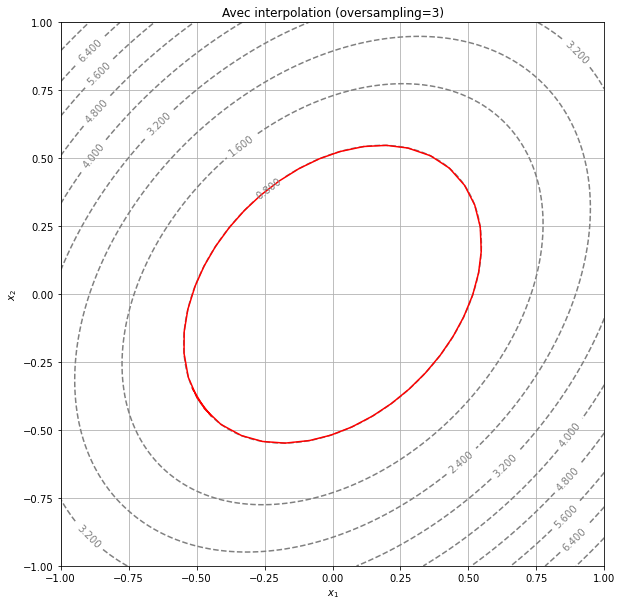

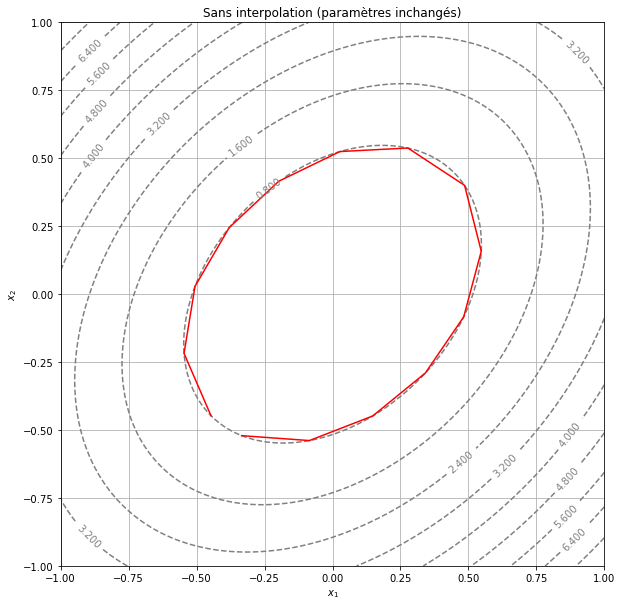

In [35]:
# Validation avec f1 :

# Choix de la courbe de niveau, et point initial
c = 0.8
x0, y0 = Newton(funct1, -0.45, -0.45)
oversampling=3

# Avec interpolation
tab = level_curve3(f1, x0, y0, oversampling, delta = 0.25, n = 500)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)


plt.plot(tab[0], tab[1], 'r')
titre = f"Avec interpolation (oversampling={oversampling})"
plt.title(titre)
plt.show()


# Sans interpolation
tab = level_curve2(f1, x0, y0, delta=0.25, n = 500)

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10
)


plt.plot(tab[0], tab[1], 'r')
plt.title("Sans interpolation (paramètres inchangés)")
plt.show()

##### Vérification graphique pour `f2`

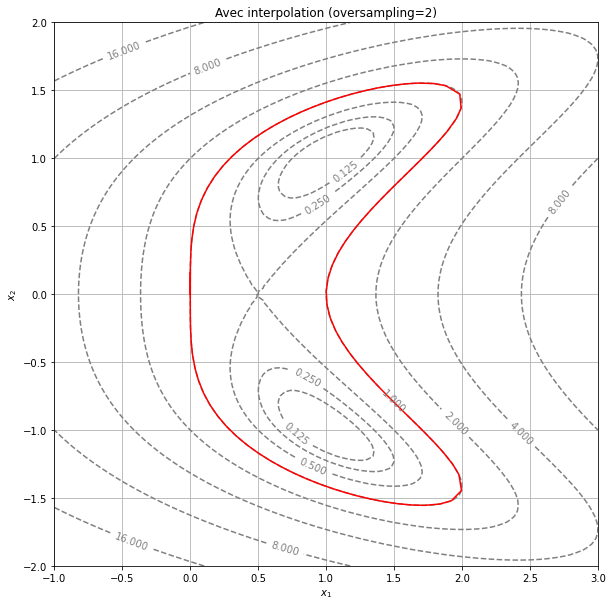

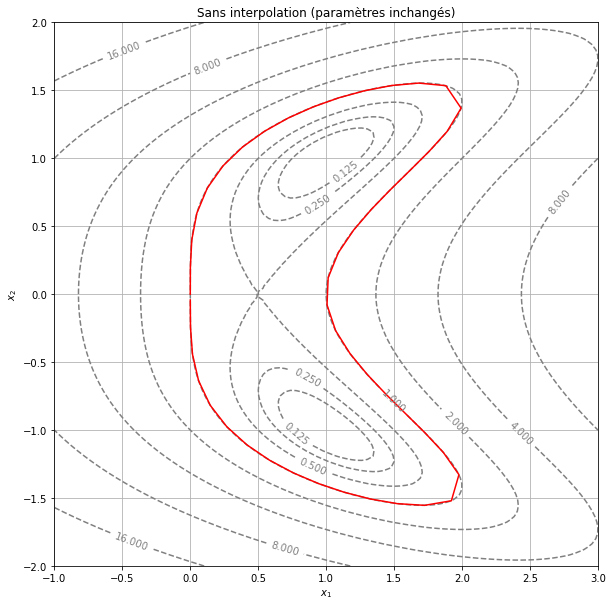

In [36]:
# Validation avec f2 :

# Choix de la courbe de niveau et du point initial
c = 1.0
x0 = 0.0
y0 = 0.0
oversampling=2


# Avec interpolation
tab = level_curve3(f2, x0, y0, oversampling, delta = 0.2, n=500)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)]
)


plt.plot(tab[0], tab[1], 'r')
titre = f"Avec interpolation (oversampling={oversampling})"
plt.title(titre)
plt.show()


# Sans interpolation
tab = level_curve2(f2, x0, y0, delta=0.2, n=500)

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)]
)

plt.title("Sans interpolation (paramètres inchangés)")
plt.plot(tab[0], tab[1], 'r')
plt.show()


##### Vérification graphique pour `f3`

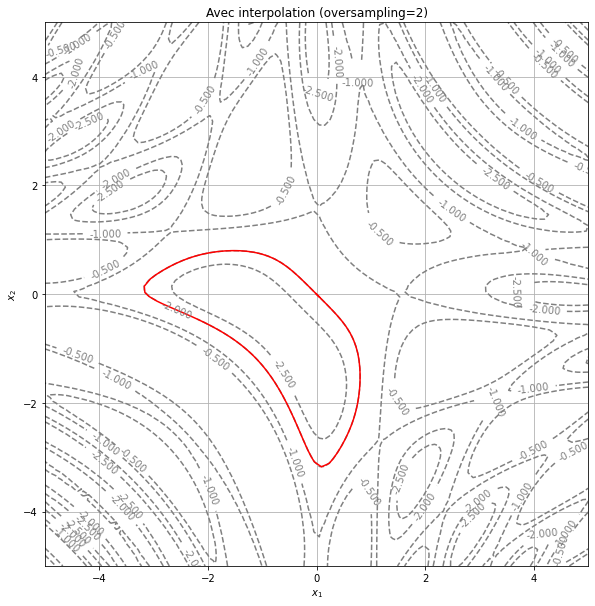

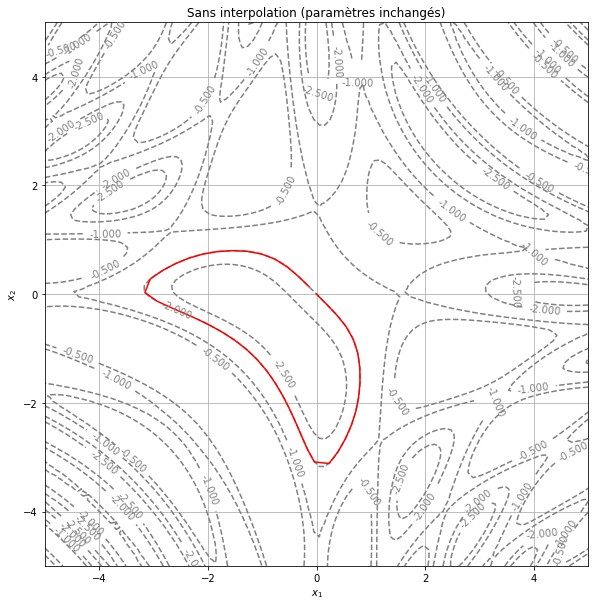

In [37]:
# Validation avec f3 :

# Choix de la courbe de niveau et du point initial
c = -2
x0 = 0.0
y0 = 0.0
oversampling=2


# Avec interpolation
tab = level_curve3(f3, x0, y0, oversampling, delta = 0.27, n=500)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100),
    levels=[-3, -2.5, -2, -1, -0.5]
)


plt.plot(tab[0], tab[1], 'r')
titre = f"Avec interpolation (oversampling={oversampling})"
plt.title(titre)
plt.show()


# Sans interpolation
tab = level_curve2(f3, x0, y0, delta = 0.27, n=500)

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100),
    levels=[-3, -2.5, -2, -1, -0.5]
)


plt.plot(tab[0], tab[1], 'r')
plt.title("Sans interpolation (paramètres inchangés)")
plt.show()